In [13]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from random import randint
import os
import pickle
from tqdm.notebook import tqdm

In [14]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        raise NotImplementedError

    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError

In [15]:
class Dense(Layer):
    def __init__(self, input_size, output_size, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
        self.m_w, self.v_w = np.zeros_like(self.weights), np.zeros_like(self.weights)
        self.m_b, self.v_b = np.zeros_like(self.bias), np.zeros_like(self.bias)
        self.t = 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights.T) + self.bias.T

    def backward(self, output_gradient, learning_rate):
        self.t += 1
        input_gradient = np.dot(output_gradient, self.weights)
        weights_gradient = np.dot(output_gradient.T, self.input)
        bias_gradient = np.sum(output_gradient, axis=0, keepdims=True).T

        self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * weights_gradient
        self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * weights_gradient**2
        m_w_hat = self.m_w / (1 - self.beta1**self.t)
        v_w_hat = self.v_w / (1 - self.beta2**self.t)
        self.weights -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)

        self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * bias_gradient
        self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * bias_gradient**2
        m_b_hat = self.m_b / (1 - self.beta1**self.t)
        v_b_hat = self.v_b / (1 - self.beta2**self.t)
        self.bias -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        return input_gradient

class Dropout(Layer):
    def __init__(self, drop_rate):
        self.drop_rate = drop_rate
        self.mask = None

    def forward(self, input):
        self.mask = np.random.rand(*input.shape) > self.drop_rate
        return input * self.mask

    def backward(self, output_gradient, learning_rate):
        return output_gradient * self.mask


In [16]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

class Tanh(Activation):
    @staticmethod
    def activation(x):
        return np.tanh(x)

    @staticmethod
    def activation_prime(x):
        return 1 - np.tanh(x) ** 2

    def __init__(self):
        super().__init__(Tanh.activation, Tanh.activation_prime)

class Sigmoid(Activation):

    @staticmethod
    def activation(x):
        x = np.clip(x, -100, 100)
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def activation_prime(x):
        sig = Sigmoid.activation(x)
        return sig * (1 - sig)

    def __init__(self):
        super().__init__(Sigmoid.activation, Sigmoid.activation_prime)

class ReLU(Activation):
    @staticmethod
    def activation(x):
        return np.maximum(0, x)

    @staticmethod
    def activation_prime(x):
        return np.where(x > 0, 1, 0)

    def __init__(self):
        super().__init__(ReLU.activation, ReLU.activation_prime)


In [17]:
class Loss:
    def loss(self, y_true, y_pred):
        raise NotImplementedError()

    def gradient(self, y_true, y_pred):
        raise NotImplementedError()

class MeanSquaredError(Loss):
    def loss(self, y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))

    def gradient(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / y_true.size

class BinaryCrossEntropy(Loss):
    def loss(self, y_true, y_pred):
        epsilon = 1e-15
        return -np.mean(np.multiply(y_true, np.log(y_pred + epsilon)) + np.multiply(1 - y_true, np.log(1 - y_pred + epsilon)))

    def gradient(self, y_true, y_pred):
        epsilon = 1e-15
        return np.divide(y_pred - y_true, np.multiply(y_pred + epsilon, 1 - y_pred + epsilon))



In [22]:
class Network(Layer):
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, input):
        output = input
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def backward(self, output_error, learning_rate):
        for layer in reversed(self.layers):
            output_error = layer.backward(output_error, learning_rate)
        return output_error

class Model:
    def __init__(self, network, loss):
        self.network = Network(network)
        self.loss = loss
        self.train_loss = []
        self.test_loss = []
        self.train_acc = []
        self.test_acc = []
    
    def train(self, x_train, y_train, x_test, y_test, epochs, batch_size=64, learning_rate=0.001, early_stop=0, verbose=True, progress_bar=False):
        test_count = x_test.shape[0]
        for epoch in range(epochs):
            perm = np.random.permutation(len(x_train))
            x_train = x_train[perm]
            y_train = y_train[perm]
            mean_loss = 0
            for i in tqdm(range(0, len(x_train), batch_size), disable=not progress_bar):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                output = self.network.forward(x_batch)
                loss = self.loss.loss(y_batch, output)
                mean_loss += loss
                loss_gradient = self.loss.gradient(y_batch, output)
                self.network.backward(loss_gradient, learning_rate)
                if early_stop > 0 and len(self.test_acc) > early_stop and self.test_acc[-1] <= self.test_acc[-early_stop]:
                    return
            mean_loss /= len(x_train) / batch_size
            self.train_loss.append(mean_loss)
            train_accu = self.test_accuracy(x_train[:test_count], y_train[:test_count])
            self.train_acc.append(train_accu)
            self.evaluate(x_test, y_test)
            if verbose:
                print(f"Epoch {epoch + 1} - Train loss: {round(self.train_loss[-1], 4)} - Test loss: {round(self.test_loss[-1], 4)} - Train acc: {round(self.train_acc[-1], 4)} - Test acc: {round(self.test_acc[-1], 4)}")
    
    def evaluate(self, x_test, y_test):
        total_loss = 0
        correct_predictions = 0
        for x, y in zip(x_test, y_test):
            output = self.network.forward(x)
            total_loss += self.loss.loss(y, output)
            if np.argmax(output) == np.argmax(y):
                correct_predictions += 1
        avg_loss = total_loss / len(x_test)
        accuracy = correct_predictions / len(x_test)
        self.test_loss.append(avg_loss)
        self.test_acc.append(accuracy)

    def predict_one(self, x):
        return self.network.forward(x)

    def predict(self, x_test):
        y_pred = []
        for x in x_test:
            y_pred.append(self.predict_one(x))
        return np.array(y_pred)

    def test_accuracy(self, x_test, y_test):
        correct_predictions = 0
        for x, y in zip(x_test, y_test):
            output = self.network.forward(x)
            if np.argmax(output) == np.argmax(y):
                correct_predictions += 1
        accuracy = correct_predictions / len(x_test)
        return accuracy        

    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            return pickle.load(f)


In [23]:
from Sources.DataLoader import load_chess_data

def one_hot_encode(x):
    one_hot = np.zeros((x.shape[0], 69, 13))
    for i in range(x.shape[0]):
        for j in range(69):
            one_hot[i][j][x[i][j]] = 1
    return one_hot

def flatten(x):
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])

def preprocess_data(x, y):
    print("One hot encoding")
    x = one_hot_encode(x)
    print("Flattening")
    x = flatten(x)
    print("Reshaping")
    x = x.reshape(x.shape[0], x.shape[1])
    y = y.reshape(y.shape[0], y.shape[1])
    print("Shuffling")
    perm = np.random.permutation(len(x))
    x = x[perm]
    y = y[perm]
    return x, y

def split_data(x, y, split):
    split_index = int(split * len(x))
    x_train, x_test = x[:split_index], x[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    return x_train, y_train, x_test, y_test

print("Loading data")
x, y = load_chess_data("datasets/equiComb.txt")
print("Preprocessing data")
x, y = preprocess_data(x, y)
x_train, y_train, x_test, y_test = split_data(x, y, 0.95)
x, y = None, None
print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)
print("X test shape:", x_test.shape)
print("Y test shape:", y_test.shape)

Loading data
Preprocessing data
Reshaping
Shuffling
X train shape: (239221, 69)
Y train shape: (239221, 4)
X test shape: (12591, 69)
Y test shape: (12591, 4)


In [24]:
layers = [
    Dense(867, 400),
    Tanh(),
    Dropout(0.5),
    Dense(400, 64),
    Tanh(),
    Dense(64, 4),
    Sigmoid()
]

model = Model(layers, BinaryCrossEntropy())
print(model.test_accuracy(x_test, y_test))
model.train(x_train, y_train, x_test, y_test, 1)

0.26852513700262093
Epoch 1 - Train loss: 1.0975 - Test loss: 0.5322 - Train acc: 0.419 - Test acc: 0.4133


In [ ]:
model.save("models/69_400_400_64_4_equiComb.pkl")

In [ ]:
model.test_accuracy(x_test, y_test)

0.43602573266619016

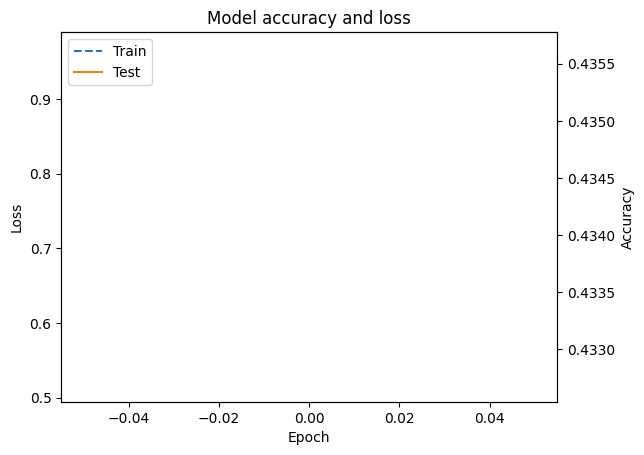

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(model.train_loss, color='tab:blue', linestyle='dashed')
ax1.plot(model.test_loss, color='tab:orange')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.set_ylabel('Accuracy')
ax2.plot(model.train_acc, color='tab:blue', linestyle='dashed')
ax2.plot(model.test_acc, color='tab:orange')
ax2.tick_params(axis='y')

plt.legend(["Train", "Test", "Train loss", "Test loss"], loc='upper left')

plt.title("Model accuracy and loss")
plt.show()

In [ ]:
model = Model.load("models/model_200_dropout_100")

FileNotFoundError: [Errno 2] No such file or directory: 'models/model_200_dropout_100'

In [ ]:
def cross_test(model, x_test, y_test):
    pred_count = [0, 0, 0, 0]
    correct_pred_count = [0, 0, 0, 0]
    reality_count = [0, 0, 0, 0]
    for x, y in zip(x_test, y_test):
        pred = np.argmax(model.predict_one(x))
        reality = np.argmax(y)
        pred_count[pred] += 1
        reality_count[reality] += 1
        if pred == reality:
            correct_pred_count[pred] += 1
    classnames = ["Checkmate", "Check", "Stalemate", "Nothing"]
    for i in range(4):
        print(f"Class: {classnames[i]}")
        print(f"Reality: {reality_count[i]}")
        print(f"Correct predictions: {correct_pred_count[i]}")
        print(f"Total Predictions: {pred_count[i]}")
        print(f"Accuracy: {round(correct_pred_count[i] / pred_count[i], 4)}")
        print()
    print(f"Total accuracy: {round(sum(correct_pred_count) / sum(pred_count), 4)}")
cross_test(model, x_test, y_test)

Class: Checkmate
Reality: 3237
Correct predictions: 1596
Total Predictions: 3030
Accuracy: 0.5267

Class: Check
Reality: 3113
Correct predictions: 1439
Total Predictions: 2820
Accuracy: 0.5103

Class: Stalemate
Reality: 3194
Correct predictions: 2875
Total Predictions: 3676
Accuracy: 0.7821

Class: Nothing
Reality: 3047
Correct predictions: 1738
Total Predictions: 3065
Accuracy: 0.567

Total accuracy: 0.6074


In [ ]:
x, y = load_chess_data("datasets/clement.txt")
x, y = preprocess_data(x, y)

print("x shape:", x.shape)
print("y shape:", y.shape)

Reshaping
Shuffling
x shape: (188120, 69)
y shape: (188120, 4)


In [ ]:
cross_test(model, x, y)

Class: Checkmate
Reality: 47030
Correct predictions: 25959
Total Predictions: 51645
Accuracy: 0.5026

Class: Check
Reality: 47030
Correct predictions: 15633
Total Predictions: 34818
Accuracy: 0.449

Class: Stalemate
Reality: 47030
Correct predictions: 44294
Total Predictions: 62021
Accuracy: 0.7142

Class: Nothing
Reality: 47030
Correct predictions: 21667
Total Predictions: 39636
Accuracy: 0.5466

Total accuracy: 0.5717
